In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import astropy.stats
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
import astropy.io.fits as fits
from astropy.modeling import models, fitting
from scipy.signal import medfilt
import scipy

import os

import calbino
import h5py
from sedpy.observate import load_filters, getSED

plt.style.use('seaborn-talk')

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


# Binospec Telluric Correction and Flux Calibration

Flux calibration code from Ben Johnson, telluric correction by `molecfit`

Run `molecfit` in `os.environ['WORK_DIR']+'/Observing/Binospec/telluric_corrections'`

Save calib files in `os.environ['BINO_DIR']+'2649_BLAS_1/calib/'`

In [55]:
calib_dir = os.environ['BINO_DIR']+'2649_BLAS_1/calib/'

# Work on sky-subtracted data?
sky_sub = True
if sky_sub:
    skysub_lab = '_skysub'
else:
    skysub_lab = ''

# Find stars on the mask

In [54]:
# Find the stars
slits = pd.read_csv(os.environ['BINO_DIR']+'2649_BLAS_1/masks/BLAS_1_slits.csv')

# fits file ext # = slits.index + 1
slits['extnum'] = slits.index + 1

stars = slits[slits.type == 'STANDARD']
stars

,slit,targetnum,name,ra,dec,pmra,pmdec,mag,priority,epoch,type,wave_start,wave_end,side,extnum
19,255,1916,f_3,188.910191,62.352588,0,0,0.001,1,2000,STANDARD,6855.558347,9378.533932,A,20
20,254,1915,f_2,188.902346,62.363999,0,0,0.001,1,2000,STANDARD,6773.112436,9296.124509,A,21


# Load data

Load binospec spectra

In [56]:
datadir12 = os.environ['BINO_DIR']+'2649_BLAS_1/reduced_data/2019.0423_red_seeing1.2_6.25hrs/'
datadir13 = os.environ['BINO_DIR']+'2649_BLAS_1/reduced_data/2019.0423_red_seeing1.3_7hrs/'
datadir   = datadir12

# 1D slit spectra
fname_extr = datadir+"obj_abs_slits_extr.fits"
if sky_sub:
    fname_extr = datadir+"obj-sky_slits_extr.fits"
extract1D  = fits.open(fname_extr)

# 2D spectra
fname_lin = datadir+"obj-sky_slits_lin.fits"
extract2D  = fits.open(fname_lin)

spec1D = extract1D['FLUX'].data
err1D  = extract1D['ERROR'].data

# Get wavelength vector
header  = extract1D['FLUX'].header
nstep   = spec1D.shape[1]
wave_nm = header['CRVAL1'] + np.linspace(0., nstep*header['CDELT1'], nstep)

## Save 1D spectra for telluric calcs

In [57]:
telluric_dir = calib_dir+'telluric_corrections/'
for i in [0,1]:    
    star_id = stars.index[i]
    spec1D_file = telluric_dir+'star%i_spec1D_uncalib%s.txt' % (star_id, skysub_lab)
    np.savetxt(spec1D_file, np.vstack((wave_nm, spec1D[star_id], err1D[star_id])).T)

# Telluric correction

Transmission spectrum $T(\lambda)$ obtained for each star using `molecfit`.

To do telluric correction (Vacca+03, Sameshina+18), assuming std star and target at same airmass:

$$ S_{corr}(\lambda) = \frac{S_{obs}}{T(\lambda - \alpha)^\beta} $$

Find $\alpha$ (accounts for wavelength shifts) and $\beta$ for each spectrum such that RMS($S_{corr}$) is minimized in telluric regions. $\alpha\sim0$, $\beta\sim1$

Text(0, 0.5, 'Transmission')

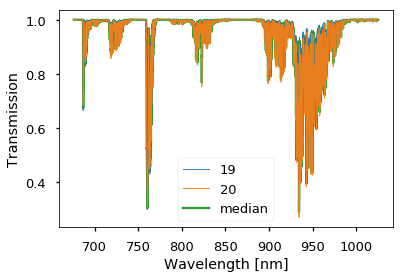

In [58]:
# Load transmission spectrum
trans_std = []
for i in [0,1]:
    star_id = stars.index[i]
    
    # Molecfit output
    spec1D_tell_file = telluric_dir+'/output/star%i_spec1D_uncalib_TAC.txt' % star_id

    tell = np.genfromtxt(spec1D_tell_file, names=True)

    trans_std.append(tell['mtrans'])
    
    plt.plot(tell['WLEN'], tell['mtrans'], lw=1, alpha=0.9, label=star_id)
    
# Take median
trans_std = np.array(trans_std)
trans_std = np.nanmedian(trans_std, axis=0)

trans_std_file = telluric_dir +'BLAS_2019A_transmission.txt'
np.savetxt(spec1D_file, np.vstack((wave_nm, trans_std)).T, header='wave_nm transmission')
np.savetxt(calib_dir+'BLAS_2019A_transmission.txt', np.vstack((wave_nm, trans_std)).T,  header='wave_nm transmission')

plt.plot(tell['WLEN'], trans_std, zorder=0, label='median')

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission')

## Mask bad telluric region of O2 lines

In [59]:
telluric_regions = {'O2 A band':[757., 775.],
                    'O2 B-band':[685., 694.]}

mask_telluric = np.array([], dtype=int)
for region in telluric_regions:
    mask_telluric = np.hstack((mask_telluric, (np.where((wave_nm > telluric_regions[region][0]) & (wave_nm < telluric_regions[region][1]))[0])))

## Telluric correction and optimization

In [60]:
def std_telluric_region(args, opt_args):
    """RMS of corrected flux in region of O2 A-band"""
    
    alpha, beta = args    
    wave, flux_in, trans_std = opt_args
    
    flux_corr = telluric_correction(wave, flux_in, trans_std, alpha, beta)
    
    return np.nanstd(flux_corr[mask_telluric])

def telluric_correction(wave, flux_in, trans_std, alpha=0., beta=1.):
    """
    Telluric correction (assuming std at same airmass as target)
    
    F_corr = F_in / T(lambda - alpha)**beta
    """
    
    # Translate and scale transmission
    transmission_function = np.interp(wave-alpha, wave, trans_std)**beta
    
    flux_out = flux_in/transmission_function
    flux_out[flux_out == 0.] = np.nan
    
    return flux_out

def optimized_tellcorr(wave, flux_in, trans_std):
    initial_guess = [0, 1.]  # initial guess can be anything
    result = scipy.optimize.minimize(std_telluric_region, initial_guess, 
                                     args=[wave, flux_in, trans_std])
    print(result.x)
    return telluric_correction(wave, flux_in, trans_std, alpha=result.x[0], beta=result.x[1])
    

initial_guess = [0, 1.]  # initial guess can be anything
result = scipy.optimize.minimize(std_telluric_region, initial_guess, 
                                 args=[tell['WLEN'], tell['FLUX'], trans_std])
print(result)

      fun: 1.9735413786281522
 hess_inv: array([[0.00140964, 0.00064837],
       [0.00064837, 0.01771588]])
      jac: array([-9.10460949e-06, -1.93715096e-07])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.00294368, 0.97930055])


# Plot 1D and 2D bino spectra of stars

[0.00655132 1.10881635]
[0.00450625 1.0732529 ]


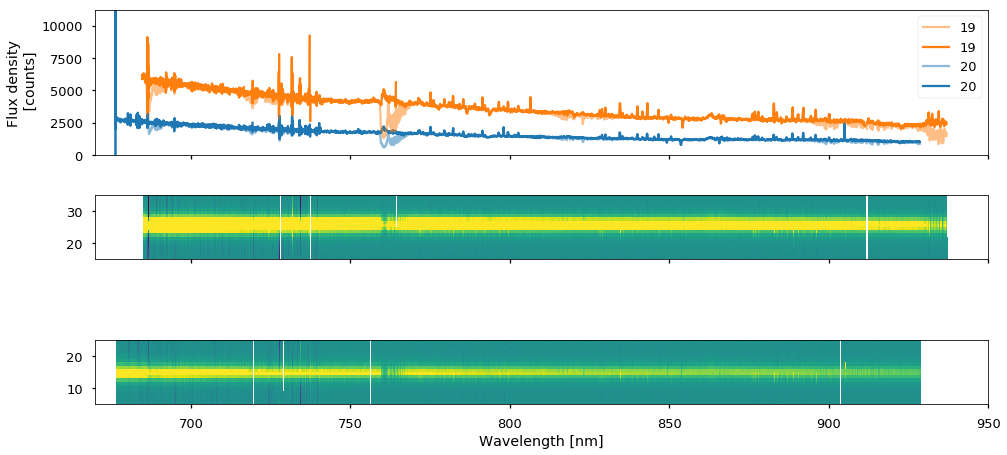

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8), sharex=True)

col = ['tab:orange','tab:blue']

for i in range(2):
    
    # 1D spectra
    ax1.plot(wave_nm, spec1D[stars.index[i]], c=col[i], alpha=0.5, label=stars.index[i])

    # exclude bad telluric region
#     spec1D_mask = spec1D[stars.index[i]].copy()
#     spec1D_mask[mask_telluric] = np.nan
#     ax1.plot(wave_nm, spec1D_mask, label=stars.index[i])

    # telluric corrected
    ax1.plot(wave_nm, optimized_tellcorr(wave_nm, spec1D[stars.index[i]], trans_std), 
             c=col[i], label=stars.index[i], zorder=0)

ax3.set_xlabel('Wavelength [%s]' % header['CUNIT1'])
try:
    ax1.set_ylabel('Flux density\n [%s]' % header['BUNIT'])
except:
    ax1.set_ylabel('Flux density\n [counts]')
    
ax1.set_ylim(0, np.nanmax(spec1D[stars.index[i]]))

ax1.legend()

# 2D spectra
vmin, vmax = -500, 500

spec2D = extract2D[stars.index[0]+1].data
ax2.imshow(spec2D, vmin=vmin, vmax=vmax, extent=[wave_nm.min(), wave_nm.max(), 0., spec2D.shape[0]])
ax2.set_ylim(15,35)

spec2D = extract2D[stars.index[1]+1].data
ax3.imshow(spec2D, vmin=vmin, vmax=vmax, extent=[wave_nm.min(), wave_nm.max(), 0., spec2D.shape[0]])
ax3.set_xlim(670,950)
ax3.set_ylim(5,25)

plt.subplots_adjust(hspace=0)

# Load a calibrator star

In [64]:
def load_star_spec(star_id, mask_pix=20, tell_corr=True):
    """
    Load star, get flux and wavelength, and coords from bino spectrum
    """

    spec1D_mask = spec1D[star_id].copy()
    if tell_corr:
        # Do telluric correction
        spec1D_mask = optimized_tellcorr(wave_nm, spec1D_mask, trans_std)
    else:
        # Mask bad telluric
        spec1D_mask[mask_telluric] = np.nan

    # Mask edges of detector
    if mask_pix == 0: 
        mask_pix = 1
    finite_mask = np.where(~np.isnan(spec1D_mask))[0]
    spec1D_mask[finite_mask[:mask_pix]]  = np.nan
    spec1D_mask[finite_mask[-mask_pix:]] = np.nan

    # And here you'd get the bino spectrum for the calibrator star.
    # data_pix, data_wave, data_flux = np.genfromtxt("star.csv", delimiter=",", unpack=True, skip_header=1)
    data_pix, data_wave, data_flux  = np.arange(nstep), wave_nm*10., spec1D_mask.copy()
    
    if sky_sub is False:
        # header units are 1e-19 erg/s/cm^2/AA [if'abs']
        data_flux = 1e-19 * data_flux.copy()

    # Get from header slit_ra?
    ra, dec = stars.loc[star_id].ra, stars.loc[star_id].dec
    mag_g, mag_r, mag_i = 23., 23.02, 23.1

    return data_wave, data_flux, ra, dec

star_id = stars.index[1]
print(star_id)

data_wave, data_flux, ra, dec = load_star_spec(star_id)

20
[0.00450625 1.0732529 ]


# Get mags

Here is where you put the SDSS mags and the bino spectrum for the star of interest


In [65]:
# This is the filters and magnitudes for the calibrator star
def get_star_mags(ra, dec, radius_arcsec=1.2, verbose=True):
    """
    Find star mags from SDSS
    """        
    if ra is not None:
        # Get mags from SDSS directly?
        pos  = coords.SkyCoord(ra, dec, unit="deg", frame='icrs')
        flds = ["ra", "dec", "psfMag_g", "psfMag_r", "psfMag_i",
                "probPSF", "run", "rerun", "camcol", "field"]
        phot = SDSS.query_region(pos, radius=radius_arcsec*u.arcsec, spectro=False,
                                 photoobj_fields=flds).to_pandas()
        phot = phot.sort_values('probPSF', ascending=False)
        
        if verbose:
            print(phot)
            
        assert phot.iloc[0]["probPSF"] > 0

        star_mags = np.array([phot.iloc[0]["psfMag_g"], phot.iloc[0]["psfMag_r"], phot.iloc[0]["psfMag_i"]])
    
    else:
        # Put them in by hand
        star_mags = np.array([mag_g, mag_r, mag_i])
        
    return star_mags
    
star_mags = get_star_mags(ra, dec)
print(star_mags)

           ra        dec    psfMag_g    psfMag_r    psfMag_i  probPSF   run  \
2  188.902312  62.364022    17.78395    17.48049    17.35731        1  2299   
3  188.902313  62.364021    17.79037    17.49385    17.37719        1  2299   
4  188.902323  62.364020    17.78346    17.48026    17.35653        1  2299   
5  188.902353  62.364013    17.84803    17.46059    17.34364        1  2304   
6  188.902356  62.364008    17.84888    17.46091    17.34662        1  2304   
7  188.902356  62.364007    17.85993    17.47871    17.36698        1  2304   
0  188.902286  62.363986 -9999.00000 -9999.00000 -9999.00000    -9999  2304   
1  188.902288  62.363982 -9999.00000 -9999.00000 -9999.00000    -9999  2304   

   rerun  camcol  field  
2    301       3     68  
3    301       3     68  
4    301       3     68  
5    301       3    210  
6    301       3    210  
7    301       3    210  
0    301       3    209  
1    301       3    209  
[17.78395 17.48049 17.35731]


# Do flux calibration and smoothing

In [66]:
# Get a reasonable set of model spectra
libwave, libflux, libparams = calbino.get_library()
filters = load_filters(["sdss_g0", "sdss_r0", "sdss_i0"])

def flux_calibration(star_mags, data_flux, data_wave):  

    # choose the model(s) with colors closest to the calibrator
    best_model = calbino.choose_model(star_mags, filters, libwave, libflux, nmod=1)

    # Now work out the normalization of the model from the average magnitude offset
    best_sed = calbino.getSED(libwave, best_model, filters)
    dm = np.mean(star_mags - best_sed, axis=-1)
    conv = np.atleast_1d(10**(-0.4 * dm))

    # Here, finally, is the fluxed model (erg/s/cm^2/AA)
    fluxed_model = best_model * conv[:, None]

    # Now get the bestest model on the same wavelength vector as the data
    z = 0.0 # redshift of the star, if known.
    a = (1 + z)
    
    fluxed_model_interp = np.interp(data_wave, libwave * a, fluxed_model[0])
    
    calibration = fluxed_model_interp / data_flux
    
    return calibration
    
def smooth_calibration(calibration, medfilt_kernel_size=101):

    # You probably want to median filter the calibration vector.  # Perhaps
    # after some sigma clipping.  differences on small scales could be due to
    # model imperfections (wrong metallicity, wrong gravity for model, LSF
    # mismatch)
    # you could also fit the calibration vector with a polynomial, taking into
    # account errors
    smoothed_calibration = medfilt(calibration, medfilt_kernel_size)
    
    return smoothed_calibration

def polyfit_calibration(wave, calibration, degree=3):

    # Fit the data using astropy.modeling
    p_init = models.Polynomial1D(degree=degree)
    calibration_masked = np.ma.masked_array(calibration, mask=np.isnan(calibration))

    fit_p = fitting.LinearLSQFitter()
    p = fit_p(p_init, wave, calibration_masked)

    # Plot the data with the best-fit model
    return p(wave)

# Run for both stars

Not much difference between masking telluric or correcting for it in the flux calibration

19
[0.00655132 1.10881635]
20
[0.00450625 1.0732529 ]
1.3119041452008973e-19


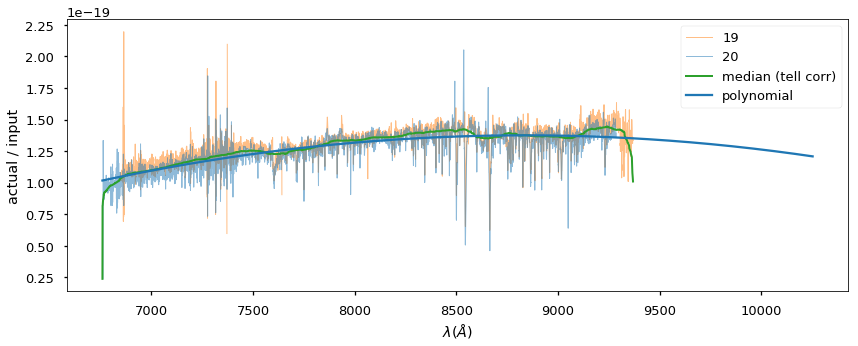

In [73]:
plt.figure(figsize=(14,5))

calibration_both = []
for i in range(2):
    star_id = stars.index[i]
    print(star_id)

    # Load spectrum
    data_wave, data_flux, ra, dec = load_star_spec(star_id, tell_corr=True, mask_pix=0)

    # Match with SDSS mags
    star_mags = get_star_mags(ra, dec, verbose=False)

    # Do flux calibration
    calibration = flux_calibration(star_mags, data_flux, data_wave)
    calibration_both.append(calibration)
    
    smoothed_calibration = smooth_calibration(calibration)

    plt.plot(data_wave, calibration, lw=1, c=col[i], label=star_id, alpha=0.5)

# Take median of 2 stars calibrations
calibration_both     = np.array(calibration_both)
calibration_both_med = np.nanmedian(calibration_both, axis=0)

# smooth
smoothed_calibration = smooth_calibration(calibration_both_med, 201)
plt.plot(data_wave, smoothed_calibration, lw=2, c='tab:green', label='median (tell corr)')

# polyfit
polyfitted_calibration = polyfit_calibration(data_wave, calibration_both_med, degree=2)
plt.plot(data_wave, polyfitted_calibration, label='polynomial')

polyfitted_calibration_file = 'BLAS_2019A_fluxcalibration_polyfit%s.txt' % skysub_lab
np.savetxt(calib_dir+polyfitted_calibration_file, np.vstack((wave_nm, polyfitted_calibration)).T, 
           header='wave_nm flux_calibration', fmt='%.5e')

plt.legend()
plt.ylabel("actual / input")
plt.xlabel("$\lambda (\AA)$")

# plt.ylim(40,100)

print(np.median(polyfitted_calibration))

#  Flux calibration plots

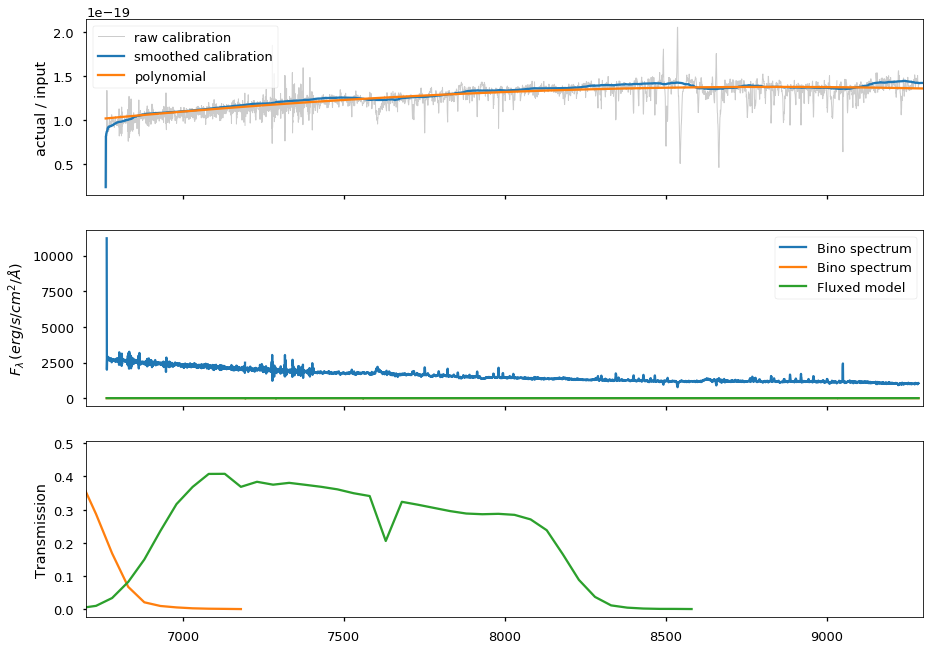

In [70]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 11))    

# Calibration
ax = axes[0]
ax.plot(data_wave, calibration, lw=1, c='0.8', label="raw calibration")
ax.plot(data_wave, smoothed_calibration, label="smoothed calibration")
ax.plot(data_wave, polyfitted_calibration, label='polynomial')
ax.legend()
# ax.set_ylim(20, 80)
ax.set_ylabel("actual / input")

# Compare flux
ax = axes[1]
ax.plot(data_wave, data_flux, label="Bino spectrum")
ax.plot(data_wave, data_flux*smoothed_calibration, label="Bino spectrum")
ax.plot(data_wave, data_flux*calibration_both_med, label="Fluxed model")
# ax.semilogy(libwave, fluxed_model[0], label="Fluxed model")
ax.set_xlim(data_wave.min(), data_wave.max())
# ax.set_ylim(1e-18, 1000e-18)
# ax.set_ylim(100e-18, 400e-18)
ax.set_xlim(6700, 9300)
# ax.set_ylim(1e-19, 3000e-19)

ax.legend()

ax.set_ylabel("$F_{\lambda} \, (erg/s/cm^2/\AA)$")

ax = axes[2]
[f.display(ax=ax) for f in filters]
ax.set_ylabel("Transmission")
ax.set_label("$\lambda (\AA)$")

# fig.savefig("example_calbino.pdf")